In [8]:
#All importing
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask
from landlab import imshowhs_grid, imshow_grid
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab import RasterModelGrid

from bmi_topography import Topography

import os
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt 
#from firemodel import *
#from fireplotter import fireplot,fluxyplot
#from create_network import create_network_from_raster
from landlab.io.netcdf import (write_netcdf, read_netcdf)
from landlab import (RasterModelGrid, imshow_grid)
from landlab.plot import graph
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler)

/home/jupyter-teodora.mitroi@col-ddce4/DEMData/SRTMGL1_39.93_-105.33_40.0_-105.26.asc
<xarray.DataArray 'SRTMGL1' (band: 1, y: 252, x: 252)>
array([[[2052, 2050, ..., 1642, 1641],
        [2062, 2056, ..., 1642, 1641],
        ..., 
        [2184, 2182, ..., 1771, 1772],
        [2185, 2185, ..., 1773, 1775]]], dtype=int32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 40.0 40.0 40.0 40.0 40.0 ... 39.93 39.93 39.93 39.93
  * x        (x) float64 -105.3 -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
Attributes:
    transform:   (0.000277777778, 0.0, -105.330138888879, 0.0, -0.00027777777...
    res:         (0.000277777778, 0.000277777778)
    is_tiled:    0
    nodatavals:  (-32768.0,)
    scales:      (1.0,)
    offsets:     (0.0,)
    units:       meters
    location:    node


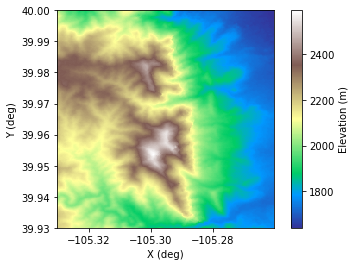

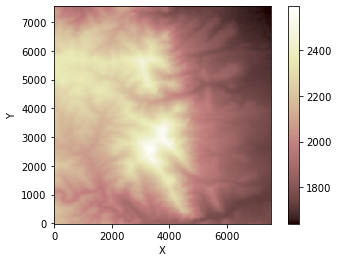

In [12]:
#Import topo
topo = Topography(
    dem_type="SRTMGL1",
    south=39.93,
    north=40.0,
    west=-105.33,
    east=-105.26,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

fname = topo.fetch()
print(fname)
dem = topo.load()
print(dem)

# Read DEM as Landlab grid
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    
#Show dem
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 'topographic__elevation',cmap =cmap,
            grid_units=("deg", "deg"),colorbar_label="Elevation (m)")
plt.show()

# make a new grid with RasterModelGrid, use the dimensions of grid_geog
grid=RasterModelGrid((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns),30)
grid.add_field('topographic__elevation',elev, at='node')
imshow_grid(grid,'topographic__elevation')

In [10]:
#Input parameters

# Grid parameters
dx = 100              # distance between each node (m) 
np.random.seed(5000) #5000  # reproducible random seed to add initial topographic roughness
grid_dim = (50,50)    # number of nodes along each axis (x,y)

# Alternate grid parameters
# These provide finer resolution at the cost of much larger runtime.
#dx = 25              # distance between each node (m) 
#np.random.seed(5000) #5000  # reproducible random seed to add initial topographic roughness
#grid_dim = (200,200)    # number of nodes along each axis (x,y)

# Timesteps, runtime, and uplift rate for Fastscape imprint time window
dt_fs = 1000                # timestep in years
runtime_fs = 2000000        # length of the simulation in years
ndt_fs = runtime_fs//dt_fs  # number of timesteps
U_fs = 0.002                # Uplift rate in m/yr

# Timesteps, runtime, and uplift rate for SPACE wildfire simulation time window
dt_sp = 1                   # timestep in years
runtime_sp = 1000           # length of the simulation in years
ndt_sp = runtime_sp//dt_sp  # number of timesteps
U_sp = 0.002                # Uplift rate in m/yr

# Fastscape Eroder parameters
K_sp=0.00001          # erodibility coefficient
m_sp=0.5              # Drainage area exponent
n_sp=1                # Slope exponent

# SPACE parameters (we will use the same K, m, and n as above)
K_sed0 = 0.00001        # Baseline soil erodiblity
K_br = 0.00001          # Bedrock erodibility coefficient
F_f = 0                 # The fraction of fine sediment that becomes suspended as washload
phi = 0                 # Sediment porosity
H_star = 1.             # Bedrock roughness scale
v_s = 0.001             # Settling length scale for entrained sediment to travel before depositing
sp_crit_sed = 0         # Critical stream power threshold required to entrain sediment
sp_crit_br = 0          # Critical stream power threshold required to erode bedrock

# Erodibility stepper
decay_time = dt_sp*15    # time it takes the erodibility perturbutions to decay

# FireGenerator 
mean_fire_recurrence=1/(30*dt_sp)          # Fire frequency in #/yr. This is one every 10
shape_parameter=1.0 #default is 0
#scale_perameter= #is optional

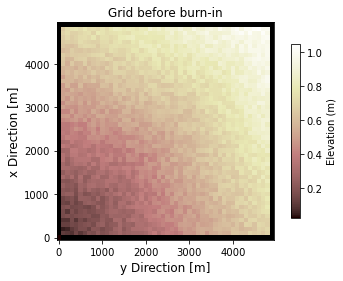

In [11]:
## Instantiate the raster model grid
mg = RasterModelGrid(grid_dim, xy_spacing=dx)
_ = mg.add_zeros('topographic__elevation', at='node')

# Add tilt and seeded random noise to the topography
mg.at_node['topographic__elevation'] += (mg.node_y / 10000. + 
                                         mg.node_x / 10000. + np.random.rand(len(mg.node_y))/10 )
mg.at_node['topographic__elevation'] += np.heaviside(mg.node_y-mg.node_x,1)*(mg.node_y-mg.node_x)/30000
mg.at_node['topographic__elevation'] += -np.heaviside(-mg.node_y+mg.node_x,1)*(mg.node_y-mg.node_x)/30000

# Set the boundary conditions
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(0, mg.at_node['topographic__elevation'], -9999.)

# Plot the initial topographic conditions
mg.imshow('node',
          'topographic__elevation',
          shrink=0.80,  # shrink controls size of colorbar
          colorbar_label='Elevation (m)'
         )
plt.title('Grid before burn-in',fontsize=12)
plt.xlabel("y Direction [m]",fontsize=12)
plt.ylabel("x Direction [m]",fontsize=12)

plt.show()